In [1]:
%run common.ipynb

['LC_Type1', 'LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LC_Type1']


In [2]:
%run tuning_common.ipynb

Using TensorFlow backend


In [3]:
MODEL_SAVE_DIR = f'{MODEL_FOLDER}/downstream-xgboost/model/'

In [4]:
downstream_train_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TRAIN_FILENAME}')
downstream_test_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TEST_FILENAME}')

In [5]:
import xgboost as xgb

In [14]:
import time
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators':[500],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

model = xgb.XGBRegressor(eval_metric='rmse')

n_iter_search = 100
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=5)
start = time.time()
random_search.fit(downstream_train_df[FEATURES], downstream_train_df[TARGET_FEATURE])
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

[23:34:01] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[23:34:01] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[23:34:01] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[23:34:01] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[23:34:01] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[23:34:03] WARNING: /croot/xgboost-split_1675457761144/work/src/learne

In [21]:
random_search.best_estimator_.save_model(f"{MODEL_SAVE_DIR}model.json")

RMSE prediction: 4613.4896
RMSE MOD17: 4555.4555
R-Squared prediction: 0.48870824359997067
R-Squared MOD17: 0.5014906468922562
Max error prediction: 13605.1111328125
Max error MOD17: 15912.398000000001
predict_df contains negative values, skip mean_poisson_deviance metrics
Mean pinball loss with alpha = 0.9 prediction: 1968.9462022561097
Mean pinball loss with alpha = 0.9 MOD17: 2451.924659054487
Mean pinball loss with alpha = 0.09999999999999998 prediction: 1528.1207059620392
Mean pinball loss with alpha = 0.09999999999999998 MOD17: 948.2646650641025


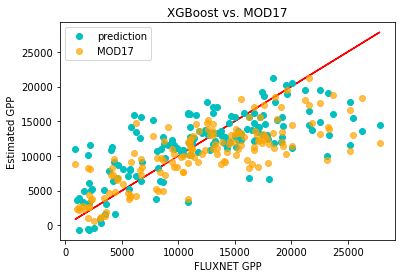

In [6]:
model2 = xgb.XGBRegressor()
model2.load_model(f"{MODEL_SAVE_DIR}model.json")
y_pred = model2.predict(downstream_test_df[FEATURES])
modis_compare_data = get_modis_compare_data(y_pred)
get_all_metrics(y_pred, modis_compare_data[TARGET_FEATURE], downstream_test_df[TARGET_FEATURE])
plot_result_distribution(downstream_test_df[TARGET_FEATURE], y_pred, modis_compare_data[TARGET_FEATURE], save_dir=f'{MODEL_RESULT_PLT_DIR}XGBoost.png', title='XGBoost vs. MOD17')